In [5]:
from data_utils import *
from model_utils import *

from tqdm import tqdm
import json

In [6]:
TRAIN_PATH = '/Users/carlo/VS_Projects/DiscreteBO/Combinatorial_BO-1/Datasets/ai-drug-discovery/training-set.csv'

## Load Data

In [50]:
# target variable
targetVar = 'sol'

# load data
df_X = getProcessedDF(df_path=TRAIN_PATH, binaryFlag=True, order=5)
df_X = df_X.drop_duplicates()
df_y = getY(df_path=TRAIN_PATH, label=targetVar)

# Load entire dataset
X = df_X.to_numpy(dtype=np.int32)
y = df_y.to_numpy()
alph1 = np.array([0.0, 2.3, -2.3, 0.0, -1.9, 0.0, -2.5, -2.3, -2.1, 0.0, 2.0, 0.0, -3.1, 2.0, 2.8, 0.0, -1.3])
y = X @ alph1.T
y = y + np.random.normal(0, 0.1, size=len(y))

f_GT = lambda x : x.T @ alph1

# derive dimensions
d = X.shape[1]
p = 1 + d + math.comb(d,2)

## Setup Oracle

In [51]:
# set dimensions
d = X.shape[1]
p = 1 + d + math.comb(d,2)

# load oracle
o1 = Oracle(fun=f_GT, N_total=5000, seed=0, sigma_2=0.2)

## Initialize BO Models

In [52]:
%%time

N_EXPERIMENTS = 15
N_ITERATIONS  = 100

# initial D_{0}
# - sample random data poitns 

# logging dicts
dictRS, dictBOCS = {}, {}

# - let BOCS explore
for it in range(N_EXPERIMENTS):
    # init oracle
    o1 = Oracle(fun=lambda x: f_bin(x, X=X, y=y), N_total=5000, seed=it*190, sigma_2=0.0)
    
    # BOCS instance
    bocs = BOCS(variant='SDP', oracle=o1, N=250, B=50, T=2, lambd=0.1, mode='min', seed=it*185)
    rs   = RandomSearch(oracle=o1, d=d, seed=it*1478)

    # init
    yList_BOCS = [np.inf]
    yList_RS   = [np.inf]
    
    # sample
    idx_0 = np.random.choice(range(len(X)), 30, replace=False)

    # - subset
    X0 = X[idx_0,:]
    y0 = y[idx_0]

    # fit BOCS on initial data
    bocs.fit(X0,y0)
    
    # loop
    for k in tqdm(range(N_ITERATIONS)):
        # append BOCS
        x_new, y_new = bocs.update()
        yList_BOCS.append(min(min(yList_BOCS), y_new))

        # append RandomSearch
        x_new, y_new = rs.update()
        yList_RS.append(min(min(yList_RS), y_new))

    # append dictionaries
    dictRS[it]   = yList_RS[1:]
    dictBOCS[it] = yList_BOCS[1:]
    
# store dictionaries
with open(f'./data/BOCS_EXP/dictRS_{N_EXPERIMENTS}_lamb01_GT_03.json', 'w+') as f:
    json.dump(dictRS, f)
with open(f'./data/BOCS_EXP/dictBOCS_{N_EXPERIMENTS}_lamb01_GT_03.json', 'w+') as f:
    json.dump(dictBOCS, f)

100%|█████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]

CPU times: user 2h 54min 40s, sys: 10min 2s, total: 3h 4min 43s
Wall time: 49min 16s


## Visualize

In [ ]:
# dataframes
df_RS   = pd.DataFrame(dictRS).T
df_BOCS = pd.DataFrame(dictBOCS).T

dictRND  = dictRS
dictBOCS = dictBOCS

In [ ]:
# Plot
fig,ax = plt.subplots()
x_ = np.array(range(10, 130))
  
# mean
y_mean  = np.array(pd.DataFrame(dictRND).mean(axis=1))
ax.plot(x_, y_mean, '--', color='tab:orange')

#plt.plot(range(20, 20+len(mseDict[0])), [mse_**2 for mse_ in mse])
plt.xticks()

# compute upper lower
y_lower = np.array(pd.DataFrame(dictRND).quantile(0.1, axis=1))
y_upper = np.array(pd.DataFrame(dictRND).quantile(0.9, axis=1))
        
# plot our confidence band
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:orange')

# compute upper lower
y_lower = np.array(pd.DataFrame(dictRND).quantile(0.25, axis=1))
y_upper = np.array(pd.DataFrame(dictRND).quantile(0.75, axis=1))
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:orange')

# compute upper lower
y_lower = np.array(pd.DataFrame(dictBOCS).quantile(0.1, axis=1))
y_upper = np.array(pd.DataFrame(dictBOCS).quantile(0.9, axis=1))
        
# plot our confidence band
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:blue')

# compute upper lower
y_mean  = np.array(pd.DataFrame(dictBOCS).mean(axis=1))
ax.plot(x_, y_mean, '--', color='tab:blue')
y_lower = np.array(pd.DataFrame(dictBOCS).quantile(0.25, axis=1))
y_upper = np.array(pd.DataFrame(dictBOCS).quantile(0.75, axis=1))
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:blue')

# ticks
plt.suptitle('Effectiveness of BOCS', fontsize=16, y=0.99)
plt.title(r'$p=56, \; \; \Vert \alpha \Vert_{0}=p, \; \; n_{init}=30, \;\; \sigma^{2}=3.0, \; \; N=100, \; \; B = 50, \; T=4$', fontsize=10)
plt.xlabel(r'$n$', fontsize=14)
plt.ylabel(r'$f(x_{t})$', fontsize=14)
plt.legend({'Rnd.Search' : 'Random', 'BOCS-SDP' : 'BOCS-SDP'})
#plt.axhline(y=0.06, linestyle='--', c='grey', linewidth=0.75, xmin=0.05, xmax=0.95)
#plt.text(s=r'$\sigma^{2} tr((X^{\top} X )^{-1})$', y=0.06, x=-26, fontsize=8, c='#525252')

plt.show()

## Visualize `rdkit`

In [53]:
from rdkit import Chem

In [54]:
df = pd.read_csv(TRAIN_PATH)

In [57]:
df['SMILES_stand'][0]

'CC(=O)SCC(Cc1ccccc1)C(=O)NCC(=O)OCc1ccccc1'

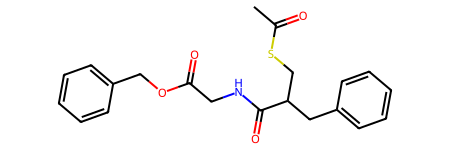

In [59]:
mol = Chem.MolFromSmiles(df['SMILES_stand'][0])
# Default
mol

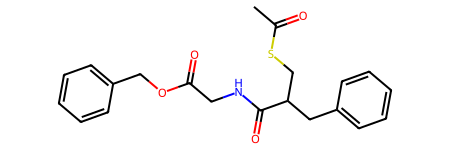

In [65]:
mol = Chem.MolFromSmiles(df['SMILES_stand'][0])
# Default
mol

In [60]:
# getFormalCharge; getNumberOfAtoms; getAromaticRings; getHydroxylGroup
from rdkit.Chem.Draw import IPythonConsole

In [87]:
m = Chem.MolFromSmiles(df['SMILES_stand'][0])
substructure = Chem.MolFromSmarts('c1ccccc1')
print(m.GetSubstructMatches(substructure))

((7, 8, 9, 10, 11, 12), (21, 22, 23, 24, 25, 26))


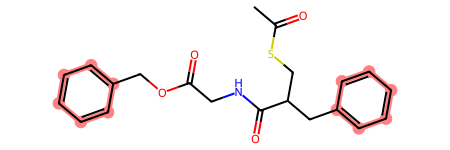

In [88]:
m

In [72]:
df['SMILES_stand'][0]

'CC(=O)SCC(Cc1ccccc1)C(=O)NCC(=O)OCc1ccccc1'

In [66]:
ri = mol.GetRingInfo()
# You can interrogate the RingInfo object to tell you the atoms that make up each ring:
print(ri.AtomRings())

((8, 9, 10, 11, 12, 7), (22, 23, 24, 25, 26, 21))


In [63]:
getAromaticRings(df['SMILES_stand'][0])

[0, 0, 0, 0]

In [64]:
getHydroxylGroup(df['SMILES_stand'][0])

[0]